In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score
import time

Preparing data

In [77]:
df = pd.read_csv('my_data/train.csv')

In [78]:
other_df = df[['Survived', 'Pclass', 'Sex', 'Age']]
other_df['Relatives'] = df.SibSp + df.Parch
other_df = other_df.dropna()
other_df.Sex.replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)

<ipython-input-78-0b3c85013a1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df['Relatives'] = df.SibSp + df.Parch


In [79]:
X = other_df.drop('Survived', axis=1)
y = other_df['Survived']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

------------------

Simple decision tree

In [81]:
clf_simple = DecisionTreeClassifier()
clf_simple.fit(X_train, y_train)
print('Train score:', clf_simple.score(X_train, y_train))
print('Test score:', clf_simple.score(X_test, y_test))

Train score: 0.7714241398030143
Test score: 0.74682039085927


In [82]:
clf_simple.get_depth()

26

In [83]:
clf_simple.feature_importances_

array([0.11790009, 0.7401389 , 0.0954973 , 0.04646372])

In [84]:
predicted = clf_simple.predict(X_test)
print('Precision:', precision_score(predicted, y_test))
print('Recall:', recall_score(predicted, y_test))

Precision: 0.672984065668759
Recall: 0.718150199665078


-------------------

Small decision tree

In [85]:
clf_small = DecisionTreeClassifier(max_depth=2)
clf_small.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [86]:
print('Train score:', clf_small.score(X_train, y_train))
print('Test score:', clf_small.score(X_test, y_test))

Train score: 0.7590802161156064
Test score: 0.7539034226036604


In [87]:
clf_small.feature_importances_

array([0.12319308, 0.87680692, 0.        , 0.        ])

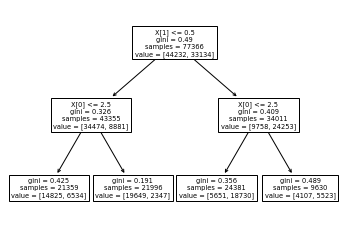

In [88]:
plot_tree(clf_small);

In [89]:
predicted = clf_small.predict(X_test)
print('Precision:', precision_score(predicted, y_test))
print('Recall:', recall_score(predicted, y_test))

Precision: 0.7251327860936746
Recall: 0.7075382803297998


-------------------

Dependency on maximal tree depth

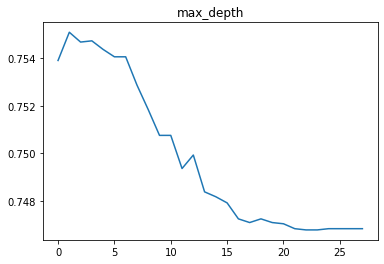

In [90]:
acc = []
for max_depth in range(2, 30):
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))
plt.plot(acc)
plt.title('max_depth')
plt.show()

------------------

Dependency on min_samples_leaf parameter

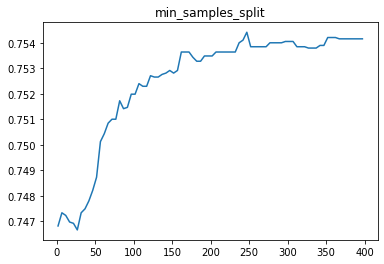

In [91]:
acc = []
values = range(2, 400, 5)
for min_samples_split in values:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))
plt.plot(values, acc)
plt.title('min_samples_split')
plt.show()

-----------------------

Dependency on min_samples_leaf parameter

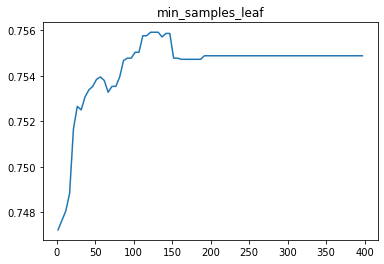

In [92]:
acc = []
values = range(2, 400, 5)
for min_samples_leaf in values:
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))
plt.plot(values, acc)
plt.title('min_samples_leaf')
plt.show()

-----------------------

Searching the best variant with RandomizedSearchCV

In [93]:
clf_best = RandomizedSearchCV(DecisionTreeClassifier(), {
    'min_samples_split': range(100, 350),
    'min_samples_leaf': range(50, 200),
    'max_depth': range(2, 15),
}, n_iter=100, cv=10)

In [94]:
start = time.time()
clf_best.fit(X_train, y_train)
print(time.time() - start)

146.56101155281067


In [95]:
print('Train score:', clf_best.score(X_train, y_train))
print('Test score:', clf_best.score(X_test, y_test))

Train score: 0.7602822945479927
Test score: 0.7548857408747802


In [96]:
clf_best.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=192, min_samples_split=226)

In [97]:
clf_best.best_estimator_.feature_importances_

array([0.1324909 , 0.8372714 , 0.00643484, 0.02380285])

In [98]:
predicted = clf_best.predict(X_test)
print('Precision:', precision_score(predicted, y_test))
print('Recall:', recall_score(predicted, y_test))

Precision: 0.7060598744567842
Recall: 0.7172286940527284


-----------------------

All the trees above give almost the same score on test dataset. In all trees the most important feature is "Sex". It was expected because the correlation between features "Survived" and "Sex" is about 0.5.

In graphs of dependency on parameters *min_samples_leaf* and *min_samples_split* score increases with increasing the parameters. It can be explained by the tree overfitting. If the parameters are too small then tree has a lot of branches. It this case tree searches not general but specific for this dataset dependency.

With increasing the *max_depth* parameter the score is decreasing by the same reasons.